
Results for 0.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.836628  0.621578   0.893519  0.733143
1      Test  0.832168  0.589928   0.845361  0.694915
2  Original  0.835738  0.615789   0.884688  0.726144


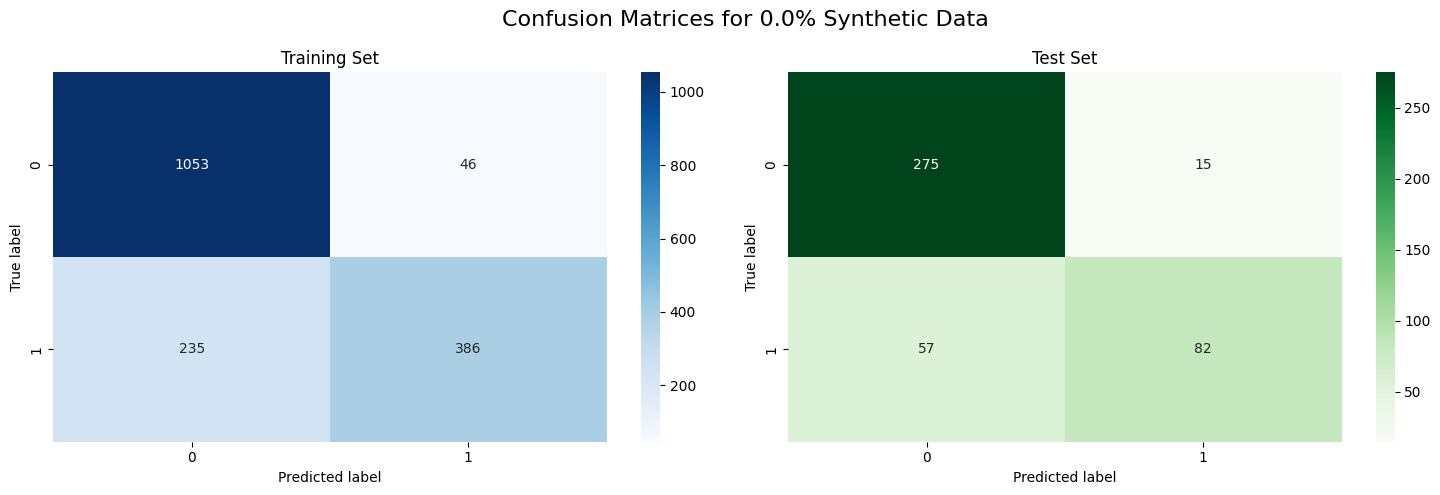

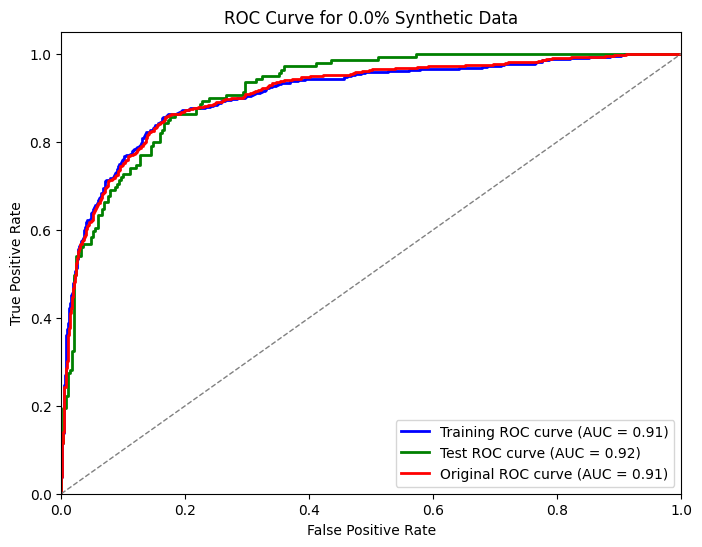


Results for 20.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.766038  0.739708   0.649942  0.691925
1      Test  0.792541  0.791367   0.647059  0.711974
2  Original  0.804095  0.780263   0.700118  0.738021


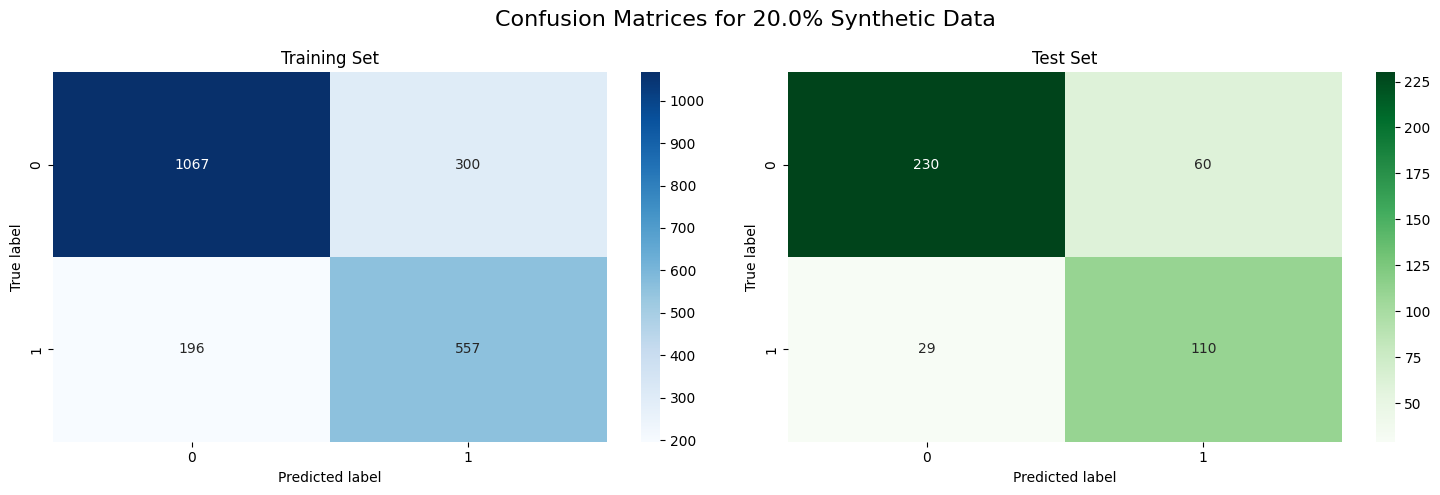

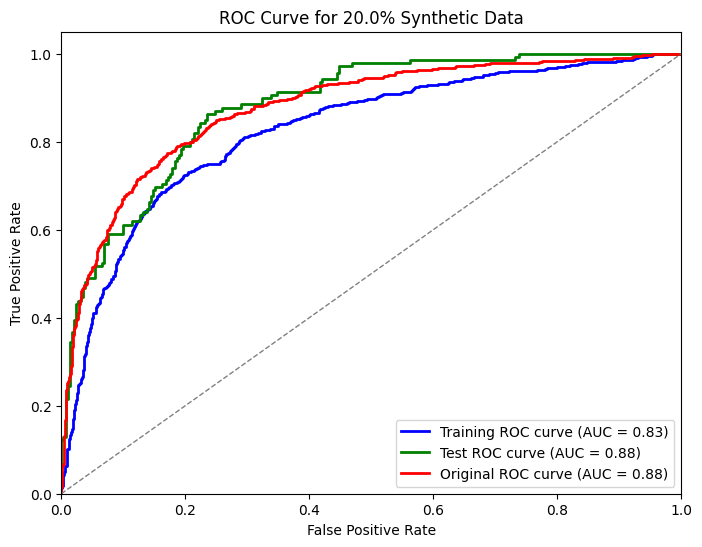


Results for 40.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.764683  0.532880   0.721966  0.613177
1      Test  0.799534  0.553957   0.762376  0.641667
2  Original  0.815263  0.590789   0.839252  0.693436


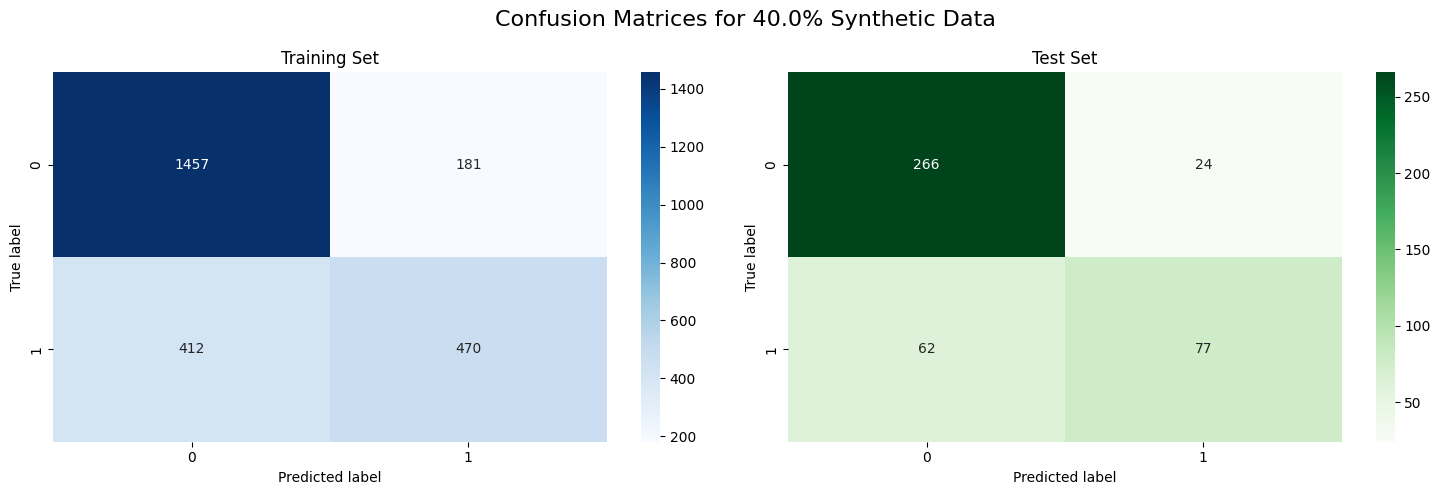

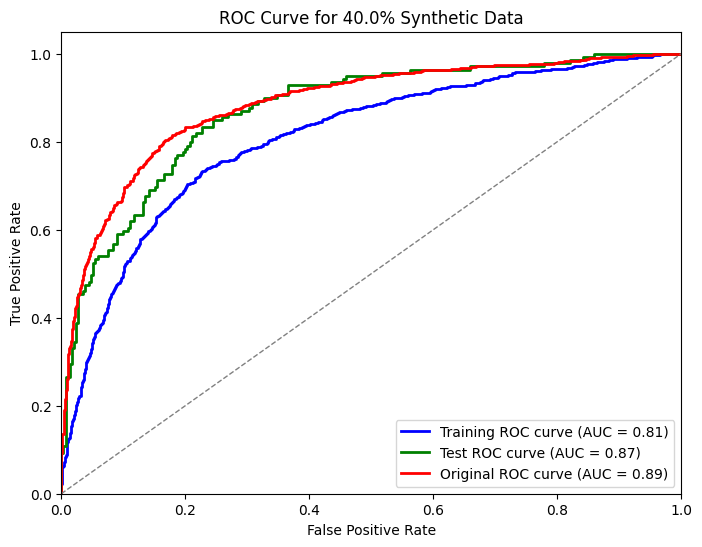


Results for 60.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.728767  0.595808   0.606707  0.601208
1      Test  0.792541  0.697842   0.673611  0.685512
2  Original  0.801768  0.705263   0.726287  0.715621


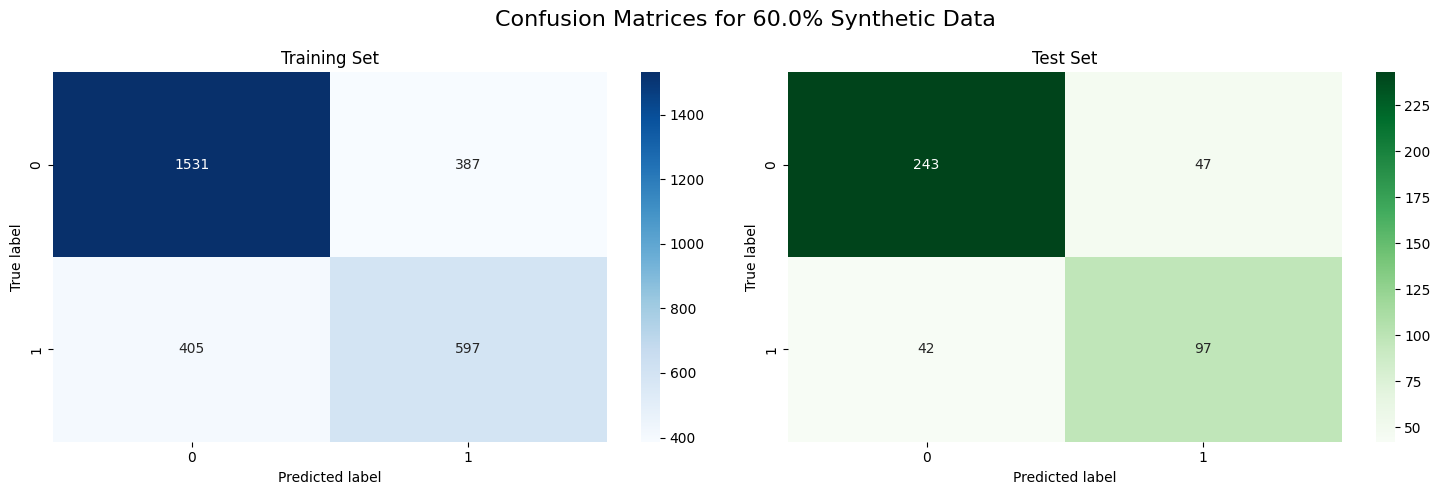

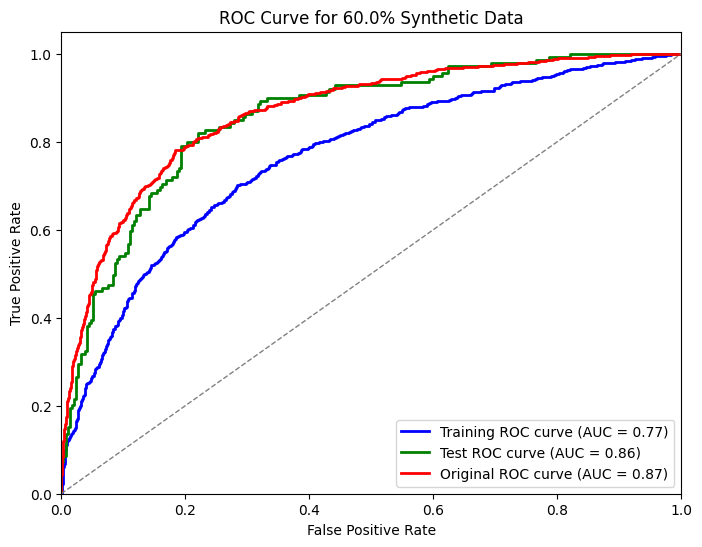


Results for 80.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.704518  0.291161   0.673347  0.406534
1      Test  0.762238  0.345324   0.813559  0.484848
2  Original  0.755235  0.360526   0.872611  0.510242


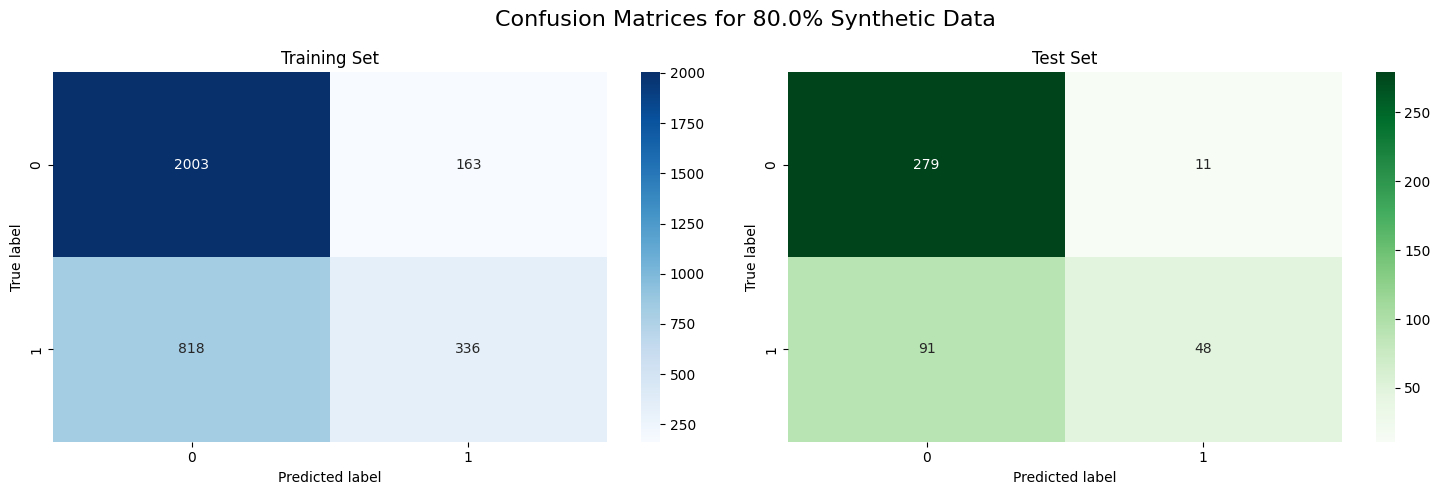

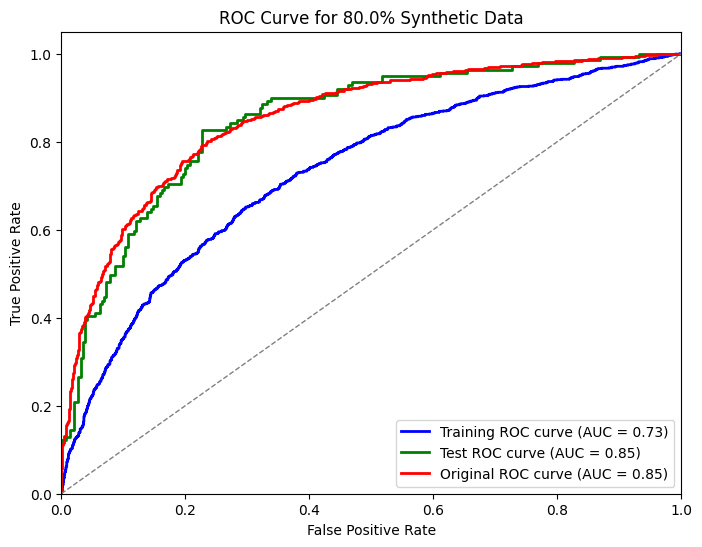


Results for 100.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.721237  0.540435   0.609115  0.572724
1      Test  0.759907  0.589928   0.640625  0.614232
2  Original  0.801303  0.677632   0.738881  0.706932


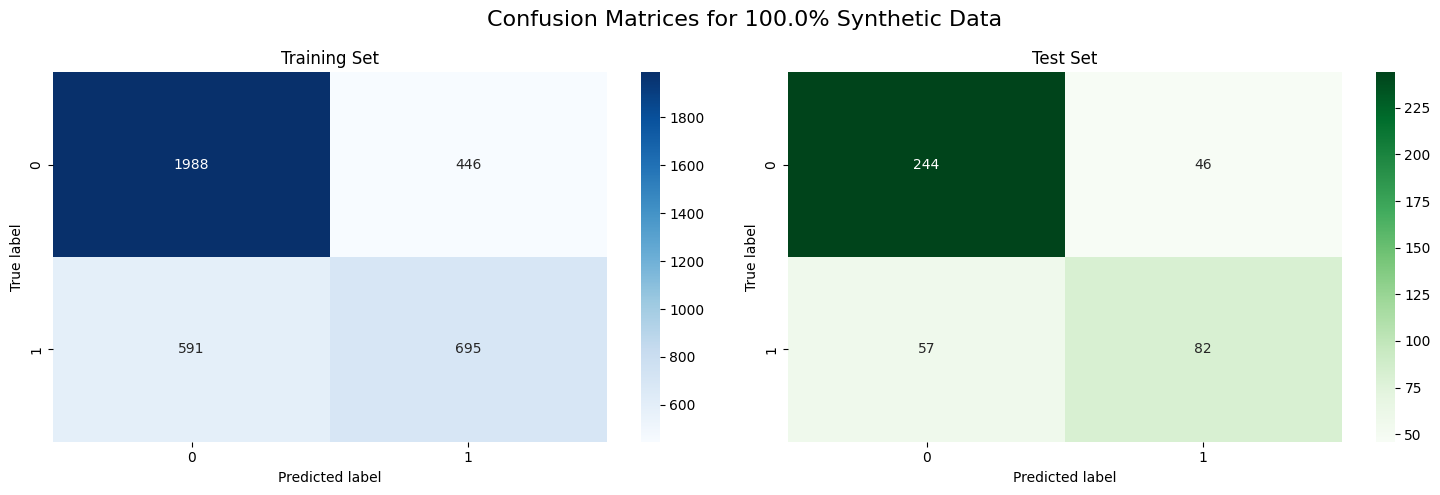

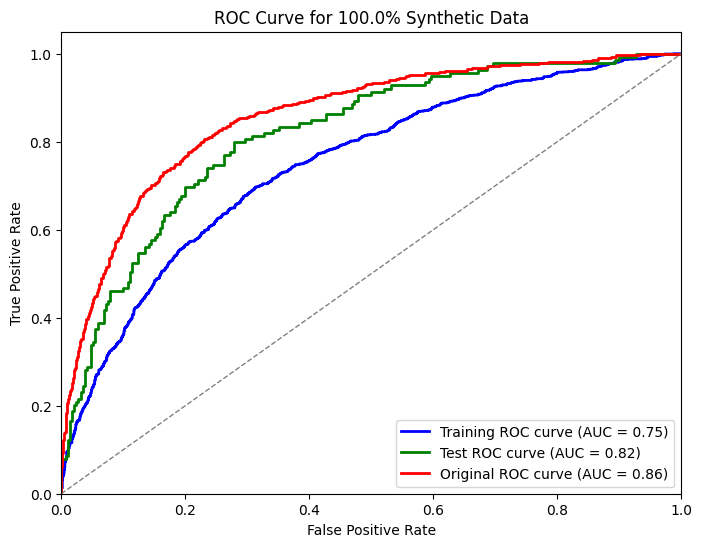

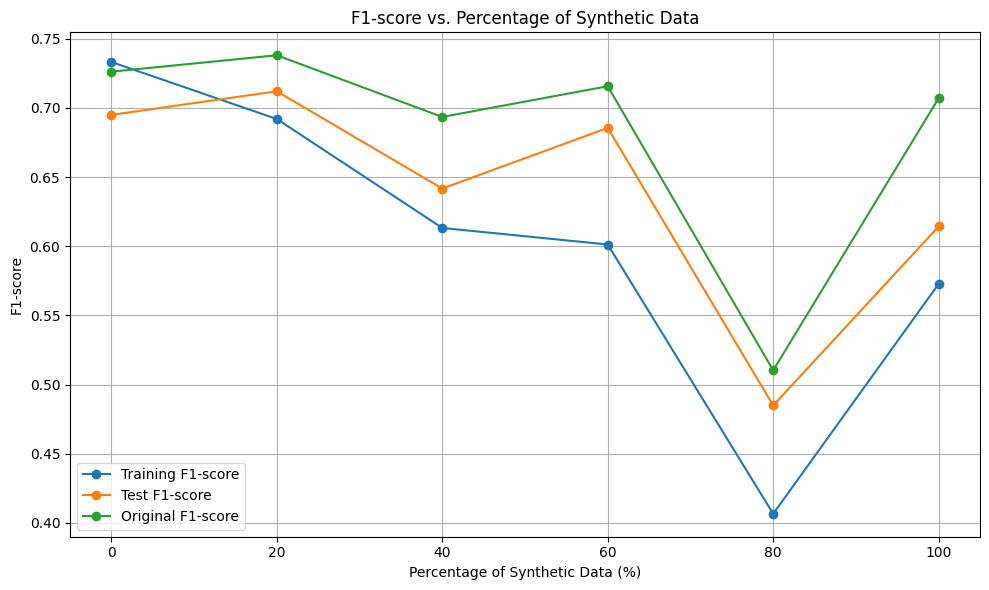

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.utils import shuffle

# Load datasets
synthetic_data_path = '../datasets/tabular/generated/alzheimers_disease_genereted.csv'
synthetic_data = pd.read_csv(synthetic_data_path)

original_data_path = '../datasets/tabular/original/alzheimers_disease_data.csv'
original_data = pd.read_csv(original_data_path)

# Drop unnecessary columns
synthetic_data = synthetic_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')
original_data = original_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred)
    }

# Define percentages of synthetic data to use (including 0%)
percentages = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Lists to store F1 scores for each dataset
f1_train_scores = []
f1_test_scores = []
f1_original_scores = []

# Manually split the original data
split_point = int(0.2 * len(original_data))
X_test = original_data.drop(columns=['Diagnosis']).iloc[:split_point]
y_test = original_data['Diagnosis'].iloc[:split_point]

# Iterate through each percentage
for percentage in percentages:
    print(f"\nResults for {percentage*100}% synthetic data:")
    
    # Calculate number of synthetic samples to use
    n_synthetic = int(len(synthetic_data) * percentage)
    
    # Combine data
    combined_data = pd.concat([original_data.iloc[split_point:], synthetic_data.iloc[:n_synthetic]], ignore_index=True)
    combined_data = shuffle(combined_data, random_state=42)
    
    # Prepare features and target for training
    X_train = combined_data.drop(columns=['Diagnosis'])
    y_train = combined_data['Diagnosis']
    
    # Train model
    model = MLPClassifier(max_iter=3000, random_state=42)
    model.fit(X_train, y_train)
    
    # Calculate metrics for training set
    y_train_pred = model.predict(X_train)
    train_metrics = calculate_metrics(y_train, y_train_pred)
    f1_train_scores.append(train_metrics['F1-score'])
    
    # Calculate metrics for test set
    y_test_pred = model.predict(X_test)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    f1_test_scores.append(test_metrics['F1-score'])
    
    # Calculate metrics for original dataset
    X_original = original_data.drop(columns=['Diagnosis'])
    y_original = original_data['Diagnosis']
    y_original_pred = model.predict(X_original)
    original_metrics = calculate_metrics(y_original, y_original_pred)
    f1_original_scores.append(original_metrics['F1-score'])
    
    # Print results
    results = pd.DataFrame({
        'Dataset': ['Training', 'Test', 'Original'],
        'Accuracy': [train_metrics['Accuracy'], test_metrics['Accuracy'], original_metrics['Accuracy']],
        'Recall': [train_metrics['Recall'], test_metrics['Recall'], original_metrics['Recall']],
        'Precision': [train_metrics['Precision'], test_metrics['Precision'], original_metrics['Precision']],
        'F1-score': [train_metrics['F1-score'], test_metrics['F1-score'], original_metrics['F1-score']]
    })
    
    print(results)
    
    # Plot confusion matrices for training and test sets only
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Confusion Matrices for {percentage*100}% Synthetic Data', fontsize=16)
    
    datasets = ['Training', 'Test']
    colors = ['Blues', 'Greens']
    
    for i, (cm, dataset) in enumerate(zip([train_cm, test_cm], datasets)):
        sns.heatmap(cm, annot=True, fmt='d', cmap=colors[i], ax=axes[i])
        axes[i].set_title(f'{dataset} Set')
        axes[i].set_ylabel('True label')
        axes[i].set_xlabel('Predicted label')

    plt.tight_layout()
    plt.show()
    
    # Plot ROC curves including the original dataset
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Calculate ROC curve for training set
    y_train_prob = model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    roc_auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')
    
    # Calculate ROC curve for test set
    y_test_prob = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
    
    # Calculate ROC curve for original dataset
    y_original_prob = model.predict_proba(X_original)[:, 1]
    fpr_original, tpr_original, _ = roc_curve(y_original, y_original_prob)
    roc_auc_original = auc(fpr_original, tpr_original)
    plt.plot(fpr_original, tpr_original, color='red', lw=2, label=f'Original ROC curve (AUC = {roc_auc_original:.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {percentage*100}% Synthetic Data')
    plt.legend(loc='lower right')
    plt.show()

# Plot F1 scores
plt.figure(figsize=(10, 6))
plt.plot([p * 100 for p in percentages], f1_train_scores, label='Training F1-score', marker='o')
plt.plot([p * 100 for p in percentages], f1_test_scores, label='Test F1-score', marker='o')
plt.plot([p * 100 for p in percentages], f1_original_scores, label='Original F1-score', marker='o')

plt.xlabel('Percentage of Synthetic Data (%)')
plt.ylabel('F1-score')
plt.title('F1-score vs. Percentage of Synthetic Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
